In [1]:
# Google Colab, clone the repository for helper functions
%rm -rf * && rm -rf .*
!git clone https://github.com/Asheeshkrsharma/Identification-OpenCows.git .

rm: refusing to remove '.' or '..' directory: skipping '.'
rm: refusing to remove '.' or '..' directory: skipping '..'
Cloning into '.'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (267/267), done.
remote: Total 566 (delta 131), reused 305 (delta 84), pack-reused 213
Receiving objects: 100% (566/566), 583.69 MiB | 37.47 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Checking out files: 100% (194/194), done.


In [1]:
# !pip3 install hiddenlayer
# !pip3 install tqdm

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet
import matplotlib.pyplot as plt

In [3]:
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message); pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/datasetLinks.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2020 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/datasetLinks.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2020
  %mv -f ./datasets/*/identification ./datasets/OpenSetCows2020/ 2>/dev/null
  %rm -rf ./datasets/10m32xl88x2b61zlkkgz3fml17
  pbar.update()
!tree -C -d -L 3 -h ./datasets

Organizing dataset: 100%|██████████| 2/2 [02:06<00:00, 63.13s/it]

/bin/bash: tree: command not found


In [ ]:
# Opencows 2021
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message);
  pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/opencows2021.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2021 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/opencows2021.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2021
  %mv -f ./datasets/*/Sub-levels ./datasets/OpenSetCows2021/ 2>/dev/null
  %rm -rf ./datasets/4vnrca7qw1642qlwxjadp87h7
  pbar.update()

Organizing dataset: 100%|██████████| 2/2 [05:31<00:00, 165.84s/it]


In [35]:
import math
import torch
from torch.nn import init
import torch.jit as jit
from torch.nn import Parameter
# from torch.jit import Tensor  # there is an error
from torch import Tensor
from typing import List, Tuple

class LSTMPCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, projection_size):
        super(LSTMPCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.projection_size = projection_size
        self.weight_ih = Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.randn(4 * hidden_size, projection_size))
        self.weight_hr = Parameter(torch.randn(projection_size, hidden_size))
        self.bias_ih = Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = Parameter(torch.randn(4 * hidden_size))
        self.init_weights()

    @jit.script_method
    def forward(self, input, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        # input: batch_size * input_size
        # state: hx -> batch_size * projection_size 
        #        cx -> batch_size * hidden_size 
        # state cannot be None
        '''
        if state is not None:
            hx, cx = state
        else:
            hx = input.new_zeros(input.size(0), self.projection_size, requires_grad=False)
            cx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
        '''
        hx, cx = state
        gates = (torch.mm(input, self.weight_ih.t()) + self.bias_ih + 
                 torch.mm(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        
        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)
        hy = torch.mm(hy, self.weight_hr.t())

        return hy, (hy, cy)
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        init.uniform_(self.weight_ih, -stdv, stdv)
        init.uniform_(self.weight_hh, -stdv, stdv)
        init.uniform_(self.weight_hr, -stdv, stdv)
        init.uniform_(self.bias_ih)
        init.uniform_(self.bias_hh)

class LSTMPLayer(jit.ScriptModule):
    # def __init__(self, cell, *cell_args):
    def __init__(self, input_size, hidden_size, projection_size):
        super(LSTMPLayer, self).__init__()
        # self.cell = cell(*cell_args)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.projection_size = projection_size
        self.cell = LSTMPCell(input_size=input_size, hidden_size=hidden_size, projection_size=projection_size)
    
    @jit.script_method
    def forward(self, input, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        # state cannot be None
        inputs = input.unbind(0)
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs), state


class LSTMCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = Parameter(torch.randn(4 * hidden_size))
        self.init_weights()

    @jit.script_method
    def forward(self, input, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        hx, cx = state
        gates = (torch.mm(input, self.weight_ih.t()) + self.bias_ih +
                 torch.mm(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        init.uniform_(self.weight_ih, -stdv, stdv)
        init.uniform_(self.weight_hh, -stdv, stdv)
        init.uniform_(self.bias_ih)
        init.uniform_(self.bias_hh)

class Lstm(nn.Module):
    def __init__(self, inputSize, embeddingSize, numLayers=1, dropout=0.0):
        super(Lstm, self).__init__()
        # self.Lstm = torch.nn.LSTM(input_size=inputSize,
        #                           hidden_size=embeddingSize,
        #                           num_layers=1, dropout=0.5, batch_first=True)
        self.Lstm = torch.nn.LSTM(
            input_size=inputSize,
            hidden_size=embeddingSize,
            num_layers=numLayers,
            dropout=dropout,
            batch_first=True,
            # bidirectional=True
        )
        for name, param in self.Lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)
        self.hidden_state = None
        self.numLayers = numLayers
        self.hiddenSize = embeddingSize

    # def reset_hidden_state(self):
    #     self.hidden_state = None

    def reset_hidden_state(self, batchSize, device):
        weight = next(self.parameters()).data
        self.hidden_state = (weight.new(self.numLayers, batchSize, self.hiddenSize).normal_(mean=0,std=1).to(device),
                      weight.new(self.numLayers, batchSize, self.hiddenSize).normal_(mean=0,std=1).to(device))
        # self.hidden_state = (weight.new(self.numLayers, batchSize, self.hiddenSize).zero_().to(device),
        #               weight.new(self.numLayers, batchSize, self.hiddenSize).zero_().to(device))

    def forward(self, x):
        output, self.hidden_state = self.Lstm(x, self.hidden_state)
        return output, self.hidden_state


class LRResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        super(LRResNetMod, self).__init__()

        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=False)
        imagenetWeights = model_zoo.load_url(
            "https://data.bris.ac.uk/datasets/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Weights/Identification/current025_model_state.pkl"
        )

        # Just needed for the loading the model weights
        self.backbone.fc_embedding = nn.Linear(1000, embeddingSize)
        self.backbone.load_state_dict(imagenetWeights["model_state"])

        # We are now going to modify this layer
        for m in self.backbone.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        numchildren = 0
        for child in self.backbone.children():
            if numchildren > 8:
              break
            for param in child.parameters():
                param.requires_grad = False
            for children_of_child in child.children():
                for param in children_of_child.parameters():
                    param.requires_grad = False
            numchildren += 1

        self.reluConv = nn.ReLU(inplace=True)

        self.lstm1 = Lstm(2048, 1024, numLayers=1, dropout=0.0)
        # self.lstm2 = Lstm(2048, 1024, numLayers=1, dropout=0.0)
        # self.lstm1 = LSTMPLayer(input_size=2048, hidden_size=1024, projection_size=512)
        # self.lstm2 = LSTMPLayer(input_size=1024, hidden_size=512, projection_size=256)
        # self.lstm2 = Lstm(1000, 512, dropout=0.0)
        self.dropout1 = nn.Dropout(0.65)
        self.dropout2 = nn.Dropout(0.65)
        self.mish = nn.Mish()
        # self.fc = nn.Linear(512, 256)

        # self.fc = nn.Sequential(
        #     nn.Linear(1024, 768),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(0.2),
        #     nn.Linear(768, 512),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(0.2),
        #     nn.Linear(512, 256),
        #     nn.ReLU(inplace=True),
        # )
        self.norm = nn.LayerNorm(1024)
        self.embedding = nn.Linear(1024, embeddingSize)
        self.embeddingSize = embeddingSize
        self.softmax = nn.Sequential(nn.Linear(1024, numClasses))

    def setupTest(self):
        self.dropout1 = nn.Dropout(0.0)
        self.dropout2 = nn.Dropout(0.0)

    def forwardOnce(self, x):
        # x has the following shape:
        # [
        #     Batch,
        #     sequence length (needs to be same for accross the batch,
        #     dynamic batching will be add later),
        #     channel,
        #     image height, image width
        # ]

        batch, timesteps, channels, h, w = x.shape
        x = x.view(batch * timesteps, channels, h, w)

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )

        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )

        # Relu(FC)
        x = x.view(x.size(0), -1)
        # Batch, number of images in each sequence, embddeing size
        x = x.view(batch, timesteps, -1)
        x = self.dropout1(self.reluConv(x))

        # Must be done before you run a new batch. Otherwise the LSTM will
        # treat a new batch as a continuation of a sequence
        self.lstm1.reset_hidden_state(batch, x.device)
        # self.lstm2.reset_hidden_state(batch, x.device)

        # initialStateLSTM1 = [x.new_zeros(timesteps, 512, requires_grad=False),
        #                     x.new_zeros(timesteps, 1024, requires_grad=False)]
        # initialStateLSTM2 = [x.new_zeros(timesteps, 256, requires_grad=False),
        #                     x.new_zeros(timesteps, 512, requires_grad=False)]

        # Batch, number of images in each sequence, embddeing size
        self.lstm1.Lstm.flatten_parameters()
        x, _ = self.lstm1(x)
        x = self.mish(x)
        x = self.dropout2(x)
        x = self.norm(x)
        # x2, _ = self.lstm2(x)
        # x2 = self.dropout(x2)
        # x2 = self.norm(x2)
        # x, _ = self.lstm2(x)
        # x, _ = self.lstm1(x, initialStateLSTM1)
        # x, _ = self.lstm2(x, initialStateLSTM2)
        # x = self.relu(self.dropout(x))
        # x = self.dropout(x)
        # x = self.relu(x)
        # x = self.norm(x)
        # x = x1 + x2
        # x = self.fc(x)
        # x = self.fc(x)
        x_t = self.embedding(x)

        # Batch, numclasses
        x_f = x_t[:, -1, :]
        # return x_t, x_f, self.softmax(x[:, -1, :])
        return x_t, x_f, self.softmax(x)

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD, _, negativeSMax = self.forwardOnce(negative)
            anchorEMBD, _, anchorSMax = self.forwardOnce(anchor)
            positiveEMBD, _, positiveSMax = self.forwardOnce(positive)

            #_, negativeEMBD, negativeSMax = self.forwardOnce(negative)
            #_, anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            #_, positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD,
                anchorEMBD,
                positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            em, anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return em, anchorEMBD, anchorSMax


In [3]:
trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "/content/utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    trackletChoiceProb=1,
    split="train",
    transform=None,
)

trainingDataLoader = DataLoader(
    trainingDataset, batch_size=1, num_workers=2, shuffle=False
)

# testingDataset = OpenSetCows2021TrackLet(
#     "/content/datasets/OpenSetCows2020",
#     "/content/utils/opencowsTracklets2020V2.json",
#     maxSequenceLength=None,
#     trackletChoiceProb=1,
#     split="test",
#     transform=None,
# )

# testingDataLoader = DataLoader(
#     testingDataset, batch_size=1, num_workers=2, shuffle=False
# )

# Calculate the channelwise mean and the standard deviation for normalisation
num_of_pixels = 0
total_sum = torch.Tensor((3))
mean = 0
for batch in trainingDataLoader:
    batch, label = batch
    batchSize, numseq, ch, h, w = batch.shape
    batch = batch.view((batchSize * numseq, ch, h, w))
    batch_sum = torch.sum(batch, axis=(0,2,3))
    total_sum += batch_sum
    num_of_pixels += numseq * batchSize * 244 * 224

# for batch in testingDataLoader:
#     batch, label = batch
#     batchSize, numseq, ch, h, w = batch.shape
#     batch = batch.view((batchSize * numseq, ch, h, w))
#     batch_sum = torch.sum(batch, axis=(0,2,3))
#     total_sum += batch_sum
#     num_of_pixels += numseq * batchSize * 244 * 224

mean = total_sum / num_of_pixels

sum_of_squared_error = torch.Tensor((3))
for batch in trainingDataLoader:
    batch, label = batch
    batchSize, numseq, ch, h, w = batch.shape
    batch = batch.view((batchSize * numseq, ch, h, w))
    # Batch wise error
    batch[:, 0, :, :] -= mean[0]
    batch[:, 1, :, :] -= mean[1]
    batch[:, 2, :, :] -= mean[2]
    batch_sum = torch.sum(batch.pow(2), axis=(0,2,3))
    sum_of_squared_error += batch_sum

# for batch in testingDataLoader:
#     batch, label = batch
#     batchSize, numseq, ch, h, w = batch.shape
#     batch = batch.view((batchSize * numseq, ch, h, w))
#     # Batch wise error
#     batch[:, 0, :, :] -= mean[0]
#     batch[:, 1, :, :] -= mean[1]
#     batch[:, 2, :, :] -= mean[2]
#     batch_sum = torch.sum(batch.pow(2), axis=(0,2,3))
#     sum_of_squared_error += batch_sum

std = torch.sqrt(sum_of_squared_error / num_of_pixels)
mean, std

KeyboardInterrupt: ignored

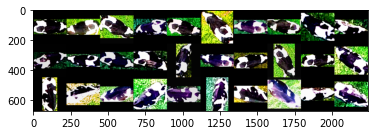

8 14
162


In [4]:
from torchvision import transforms

trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "/content/utils/opencowsTracklets2020V2.json",
    maxSequenceLength=10,
    trackletChoiceProb=1,
    split="train",
    # transform=transforms.Normalize(
    #     [0.2403, 0.2595, 0.2305],
    #     [0.3107, 0.3184, 0.3061]
    # ),
    transform=transforms.Compose(
        [
            transforms.Normalize([0.2403, 0.2595, 0.2305], [0.3107, 0.3184, 0.3061]),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        ],
    ),
)

# Test
negative, anchor, positive, positiveLabel, negativeLabel = trainingDataset.__getitem__(
    12
)
anc = [a.permute(1, 2, 0).numpy() for a in anchor]
pos = [a.permute(1, 2, 0).numpy() for a in positive]
neg = [a.permute(1, 2, 0).numpy() for a in negative]

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img if horizontal == 1 else img for img in images],
    axis=horizontal,
)

plt.imshow(compose([compose(anc, 1), compose(pos, 1), compose(neg, 1)], 0))
plt.show()
print(positiveLabel, negativeLabel)
print(len(trainingDataset))


In [5]:
import torch.nn.functional as F
from utils.mining import HardestNegativeTripletSelector

def evaluate(model, dataLoader, device, lossFn):
    """Evaluates a loss on a dataset

    Parameters
    ----------
    model : Resnet model
        nn.Module
    dataLoader : testing/training dataset
        nn.DataLoader
    device : a GPU or a CPU
        str
    lossFn : Loss function
        nn.Module

    Returns
    -------
    Loss: Evaluated loss
        Number
    """
    model.eval()
    losses = []
    for step, (negatives, anchor, positives, positiveLabel, negativeLabel) in enumerate(
        dataLoader
    ):
        negatives, anchor, positives = (
            negatives.to(device),
            anchor.to(device),
            positives.to(device),
        )
        positiveLabel, negativeLabel = (
            positiveLabel.view(len(positiveLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device),
        )

        # The forward method returns three embeddings
        negativeEMBD, anchorEMBD, positiveEMBD, labels = model(
            anchor, negatives, positives
        )
        loss, rpl, interframe = lossFN(
            negativeEMBD, anchorEMBD,
            positiveEMBD, labels,
            torch.cat((positiveLabel, positiveLabel, negativeLabel), dim=0),
        )
        losses.append(loss.data)
        if step > 10:
          break
    return sum(losses) / len(losses)

class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input=None, target=None):
        pred, labels = input, target
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

# Reciprocal Triplet loss
class RTL(nn.Module):
    def __init__(self):
        super(RTL, self).__init__()

    def d(self, anchor, instance):
        # return (anchor - instance).pow(2).sum(-1).sum(-1).sum()
        return (anchor - instance).pow(2).sum(-1).mean()
        # return (anchor - instance).pow(2).sum(1).mean()

    def forward(self, negative, anchor, positive, prediction=None, target=None):
        # return self.d(anchor, positive) + (1 / self.d(anchor, negative)) + (1 / self.d(positive, negative))
        return self.d(anchor, positive) + (1 / self.d(anchor, negative))

class RTLSL(nn.Module):
    def __init__(self, _lambda=0.01, tripletHardening=False):
        super(RTLSL, self).__init__()
        self._lambda = _lambda
        self.selector = HardestNegativeTripletSelector()
        self.RTL = RTL()
        self.CE = nn.CrossEntropyLoss(label_smoothing=0.5)
        self.device = device
        self.tripletHardening = tripletHardening
        # self.CE = nn.CrossEntropyLoss()
        # self.CE = NormalizedCrossEntropy(46)

    def hamm(self, total_data):
        hann_array = 0.5 - 0.5 * torch.cos((2 * torch.pi * torch.arange(0, total_data, 1)) / (total_data - 1))
        hann_array -= 1
        hann_array /= sum(hann_array)
        return hann_array

    def forwardOnce(self, negative, anchor, positive, prediction, target):
        rtlLoss = self.RTL(negative, anchor, positive)
        entropy = self.CE(input=prediction, target=target - 1)
        return self._lambda * rtlLoss + entropy

    def frameLevel(self, anchor, negative, positive):
        batchSize, seqLength, _ = anchor.shape
        window = self.hamm(seqLength).to(self.device)
        window = torch.linspace(1, 0, seqLength).to(device)

        # a = torch.mul((anchor - torch.flip(anchor, [1])).pow(2).sum(2), window).sum(1).sum()
        # b = torch.mul((negative - torch.flip(negative, [1])).pow(2).sum(2), window).sum(1).sum()
        # c = torch.mul((positive - torch.flip(positive, [1])).pow(2).sum(2), window).sum(1).sum()
        a = torch.mul((anchor - torch.flip(anchor, [1])).pow(2).sum(2), window).sum(1).mean()
        b = torch.mul((negative - torch.flip(negative, [1])).pow(2).sum(2), window).sum(1).mean()
        c = torch.mul((positive - torch.flip(positive, [1])).pow(2).sum(2), window).sum(1).mean()
        return a + b + c

    def forward(self, negative, anchor, positive, prediction, target):
        interFrame = self.frameLevel(anchor, negative, positive)

        # Mining
        batchsize, seqlength, _ = anchor.shape
        if self.tripletHardening:
          # Combine the embeddings from each network
          embeddings = torch.cat((anchor, positive, negative), dim=0)
          embeddings = embeddings.view((batchsize * 3 * seqlength, -1))[:100]
          targetM = torch.repeat_interleave(target, seqlength).view((-1, 1))[:100]

          # embeddings = torch.cat((anchor[:, -1, :], positive[:, -1, :], negative[:, -1, :]), dim=0)
          # targetM = target.view((-1, 1))
          # Concatenate labels for softmax/crossentropy targets
          triplets, numtriplets = self.selector.get_triplets(embeddings, targetM)
          # There might be no triplets selected, if so, just compute the loss over the entire
          # minibatch
          if numtriplets == 0:
              totalLoss = self.forwardOnce(negative[:, -1, :], anchor[:, -1, :], positive[:, -1, :], prediction, target)
          else:
              anchorEMBD, positiveEMBD, negativeEMBD = embeddings[triplets[:, 0]], embeddings[triplets[:, 1]], embeddings[triplets[:, 2]] 
              totalLoss = self.forwardOnce(negativeEMBD, anchorEMBD, positiveEMBD, prediction, target)
        else:
          totalLoss = self.forwardOnce(negative[:, -1, :], anchor[:, -1, :], positive[:, -1, :], prediction, target)
        # print(interFrame)
        # totalLoss = 0
        # for i in range(10):
        #   idx = torch.randperm(negtive.nelement())
        #   negative = negative.view(-1)[idx].view(negative.size())
        #   totalLoss += self.forwardOnce(negative, anchor, positive, prediction, target)
        # totalLoss /= 10.
        
        # return  totalLoss + interFrame, totalLoss.item(), interFrame.item()
        return  totalLoss, totalLoss.item(), interFrame.item()

**Merge the entire dataset (train test), and then generate train test splits. This clearly seems to be a combination of class imbalance and high sequence length variability.**

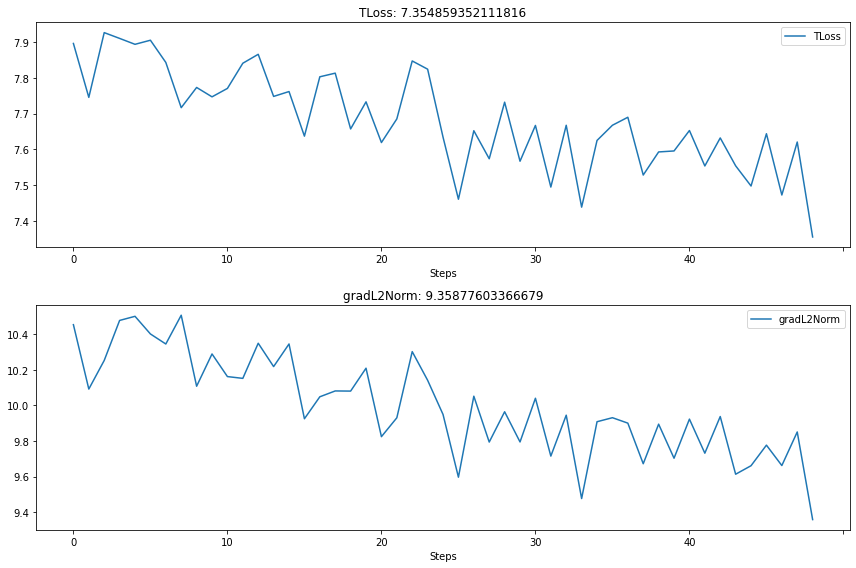

7.446017265319824, 430.312255859375: 100%|██████████| 50/50 [19:04<00:00, 22.89s/it]


In [64]:
def calculateGradientNorm(model):
    total_norm = 0
    parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
    for p in parameters:
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

trainingDataset = OpenSetCows2021TrackLet(
     "/content/datasets/OpenSetCows2020",
    "/content/utils/opencowsTracklets2020V2.json",
    maxSequenceLength=5,
    transform=transforms.Compose(
        [
            transforms.Normalize([0.2403, 0.2595, 0.2305], [0.3107, 0.3184, 0.3061]),
            transforms.RandomVerticalFlip(p=0.9),
            transforms.RandomHorizontalFlip(p=0.9),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomRotation(20)
        ],
    ),
    trackletChoiceProb = 0.9,
)

# testingDataset = OpenSetCows2021TrackLet(
#     "/content/datasets/OpenSetCows2021",
#     "utils/opencowsTracklets.json",
#     maxSequenceLength=5,
#     transform=False,
#     split="test",
#     trackletChoiceProb = 0.0,
# )

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# There are 155 individuals in the dataset
model = LRResNetMod(46)
model.to(device)

# Working parameter (71%)
trainingDataLoader = DataLoader(
    trainingDataset, batch_size=30, num_workers=2, shuffle=True
)

# testingDataLoader = DataLoader(
#     testingDataset, batch_size=10, num_workers=1, shuffle=True
# )

optimiser = optim.SGD(model.parameters(), momentum=0.3, lr=1e-3, weight_decay=0.1)
# optimiser = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

# We will use cross entropy loss for the training
lambdaFactor = 0.05
# lossFN = RTLSL(lambdaFactor, tripletHardening=True)
lossFN = RTLSL(lambdaFactor)
# lossFN = nn.CrossEntropyLoss(label_smoothing=0.6)

loss, numEpochs = 0, 50

# To store the training history
history, canvas = hl.History(), hl.Canvas()

gradientNorms = []
with tqdm(range(numEpochs), desc="Training epochs", position=0) as pbar:
    pbar.refresh()
    # Start training
    model.train()
    for epoch in range(numEpochs):
        # Prepare a batch of 5 sequences with 10 images each
        # with three channels and (224, 224) size
        negatives, anchor, positives, positiveLabel, negativeLabel = next(
            iter(trainingDataLoader)
        )
        negatives, anchor, positives = (
            negatives.to(device),
            anchor.to(device),
            positives.to(device),
        )
        positiveLabel, negativeLabel = (
            positiveLabel.view(len(positiveLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device),
        )
        # Calculate loss and Back propagate
        def backPropagate():
            optimiser.zero_grad()
            negativeEMBD, anchorEMBD, positiveEMBD, labels = model(
                anchor, negatives, positives
            )
            # print(labels.shape, target.shape)
            # Batch, seqlength, numlabels to Batch * seqlength, numlabels
            b, s, n = labels.shape
            labels = labels.view((b*s, n))
            target = torch.repeat_interleave(torch.cat((positiveLabel, positiveLabel, negativeLabel), dim=0), s)
            # # print(lossFN.frameLevel(anchorEMBD, negativeEMBD, positiveEMBD))
            loss, rpl, interframe = lossFN(
                negativeEMBD, anchorEMBD,
                positiveEMBD, labels,
                target,
            )
            # loss = lossFN(input=labels, target=target - 1)
            # rpl, interframe = 0, 0
            loss.backward()
            return loss, rpl, interframe

        loss, rpl, interframe = optimiser.step(backPropagate)

        # Gradient Norm Clipping
        gradientNorms.append(calculateGradientNorm(model))
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0, norm_type=2)
        # gradientNorms.append(calculateGradientNorm(model))
        # nn.utils.clip_grad_norm_(model.parameters(), numpy.percentile(gradientNorms, 10))

        # Every second iteration, calculate model accuracy, evaluate the loss
        # function on the test dataset. Save the experiment history
        # if epoch % 2 == 0 and epoch > 5:
        history.log(epoch, TLoss=loss.data, gradL2Norm=gradientNorms[-1])
        if epoch % 2 == 0:
            # Vloss = evaluate(model, testingDataLoader, device, RTLSL(lambdaFactor))
            # history.log(epoch, TLoss=loss.data, VLoss=Vloss)
            model.train()
            with canvas:
                # canvas.draw_plot([history["TLoss"], history["VLoss"]])
                canvas.draw_plot([history["TLoss"]])
                canvas.draw_plot([history['gradL2Norm']])
        pbar.set_description("{}, {}".format(rpl, interframe))
        pbar.update()
        # break
    pbar.refresh()


In [67]:
import matplotlib.lines as mlines
import matplotlib.patheffects as PathEffects

modelPrefix = 'LRCNN'
torch.save(model.state_dict(), f"./models/{modelPrefix}.pth")

In [68]:
def infer(dataset, model):
    embeddings, labels  = numpy.zeros((1, 128)), numpy.zeros((1))
    embeddingsAll, labelsAll  = numpy.zeros((1, 128)), numpy.zeros((1))
    indeces = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(dataset.__len__()), desc="Inferencing tracklets"):
        tracklet, label = dataset.__getitem__(i)

        tracklet = tracklet.to(device)
        all, embd, pred = model(tracklet[None, :])

        all = all.data.cpu().numpy()
        indeces.append((len(embeddingsAll) - 1, (len(embeddingsAll) - 1) + len(all[0])-1))

        embeddingsAll = numpy.concatenate((embeddingsAll, all[0]), axis=0)
        labelsAll = numpy.concatenate((labelsAll, numpy.ones(tracklet.shape[0]) * label))
        embeddings = numpy.concatenate((embeddings, embd.data.cpu().numpy()), axis=0)
        labels = numpy.concatenate((labels, numpy.array([label])), axis=0)

    embeddings, labels = embeddings[1:], labels[1:]
    embeddingsAll, labelsAll = embeddingsAll[1:], labelsAll[1:]
    return embeddingsAll, labelsAll, embeddings, labels, indeces

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LRResNetMod(46)
model.load_state_dict(torch.load(f"./models/{modelPrefix}.pth"))
model.to(device)
model.setupTest()

trainingDataset = OpenSetCows2021TrackLet(
     "/content/datasets/OpenSetCows2020",
    "/content/utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=transforms.Normalize(
        [0.2403, 0.2595, 0.2305],
        [0.3107, 0.3184, 0.3061]
    ),
    split='train',
    trackletChoiceProb = 1,
)

testingDataset = OpenSetCows2021TrackLet(
     "/content/datasets/OpenSetCows2020",
    "/content/utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=transforms.Normalize(
        [0.2403, 0.2595, 0.2305],
        [0.3107, 0.3184, 0.3061]
    ),
    split='test',
    trackletChoiceProb = 1,
)

print('Get test embeddings')
testEmbeddingsAll, testLabelsAll, testEmbeddings, testLabels, testIdeces = infer(testingDataset, model)

print('Get train embeddings')
trainEmbeddingsAll, trainLabelsAll, trainEmbeddings, trainLabels, trainIdeces = infer(trainingDataset, model)

Get test embeddings


Inferencing tracklets: 100%|██████████| 77/77 [00:03<00:00, 22.80it/s]


Get train embeddings


Inferencing tracklets: 100%|██████████| 162/162 [01:54<00:00,  1.41it/s]


In [69]:
# Model accuracy
accuracy = lambda p, l:  numpy.mean(p.astype(int).ravel() == l.astype(int).ravel()) * 100

KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
KNN.fit(trainEmbeddingsAll, trainLabelsAll - 1)

# We compare just the last output for the evaluating the model accuracy
print("KNN accuracy: {}%".format(accuracy(KNN.predict(trainEmbeddings), trainLabels - 1)))
print("KNN accuracy: {}%".format(accuracy(KNN.predict(testEmbeddings), testLabels - 1)))

# So predict based on the entrire tracklets?
predictions = KNN.predict(testEmbeddingsAll)
frequent = lambda a : max(set(a), key = a.count)
sequencePred,  targets = [], []
for start, end in testIdeces:
  sequencePred.append(frequent(list(predictions[start : end])))
  targets.append(frequent(list(testLabelsAll[start : end])))
sequencePred, targets = numpy.asarray(sequencePred), numpy.asarray(targets)
print("KNN accuracy: {}%".format(accuracy(sequencePred, targets - 1)))

KNN accuracy: 100.0%
KNN accuracy: 22.07792207792208%
KNN accuracy: 16.883116883116884%


In [ ]:
# !pip3 install umap-learn
# import umap
# fit = umap.UMAP(n_neighbors=5)
# reduction = fit.fit_transform(trainEmbeddingsAll, y=trainLabelsAll - 1)


In [ ]:
# import matplotlib.pyplot as plt
# plt.scatter(reduction[:, 0], reduction[:, 1])

In [13]:
# perplexity mentioned in the paper is 30, rest arguments are mentioned as useful defaults
tSNE = TSNE(n_components=2, learning_rate='auto', perplexity=8, init='pca')
reduction = tSNE.fit_transform(trainEmbeddingsAll)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


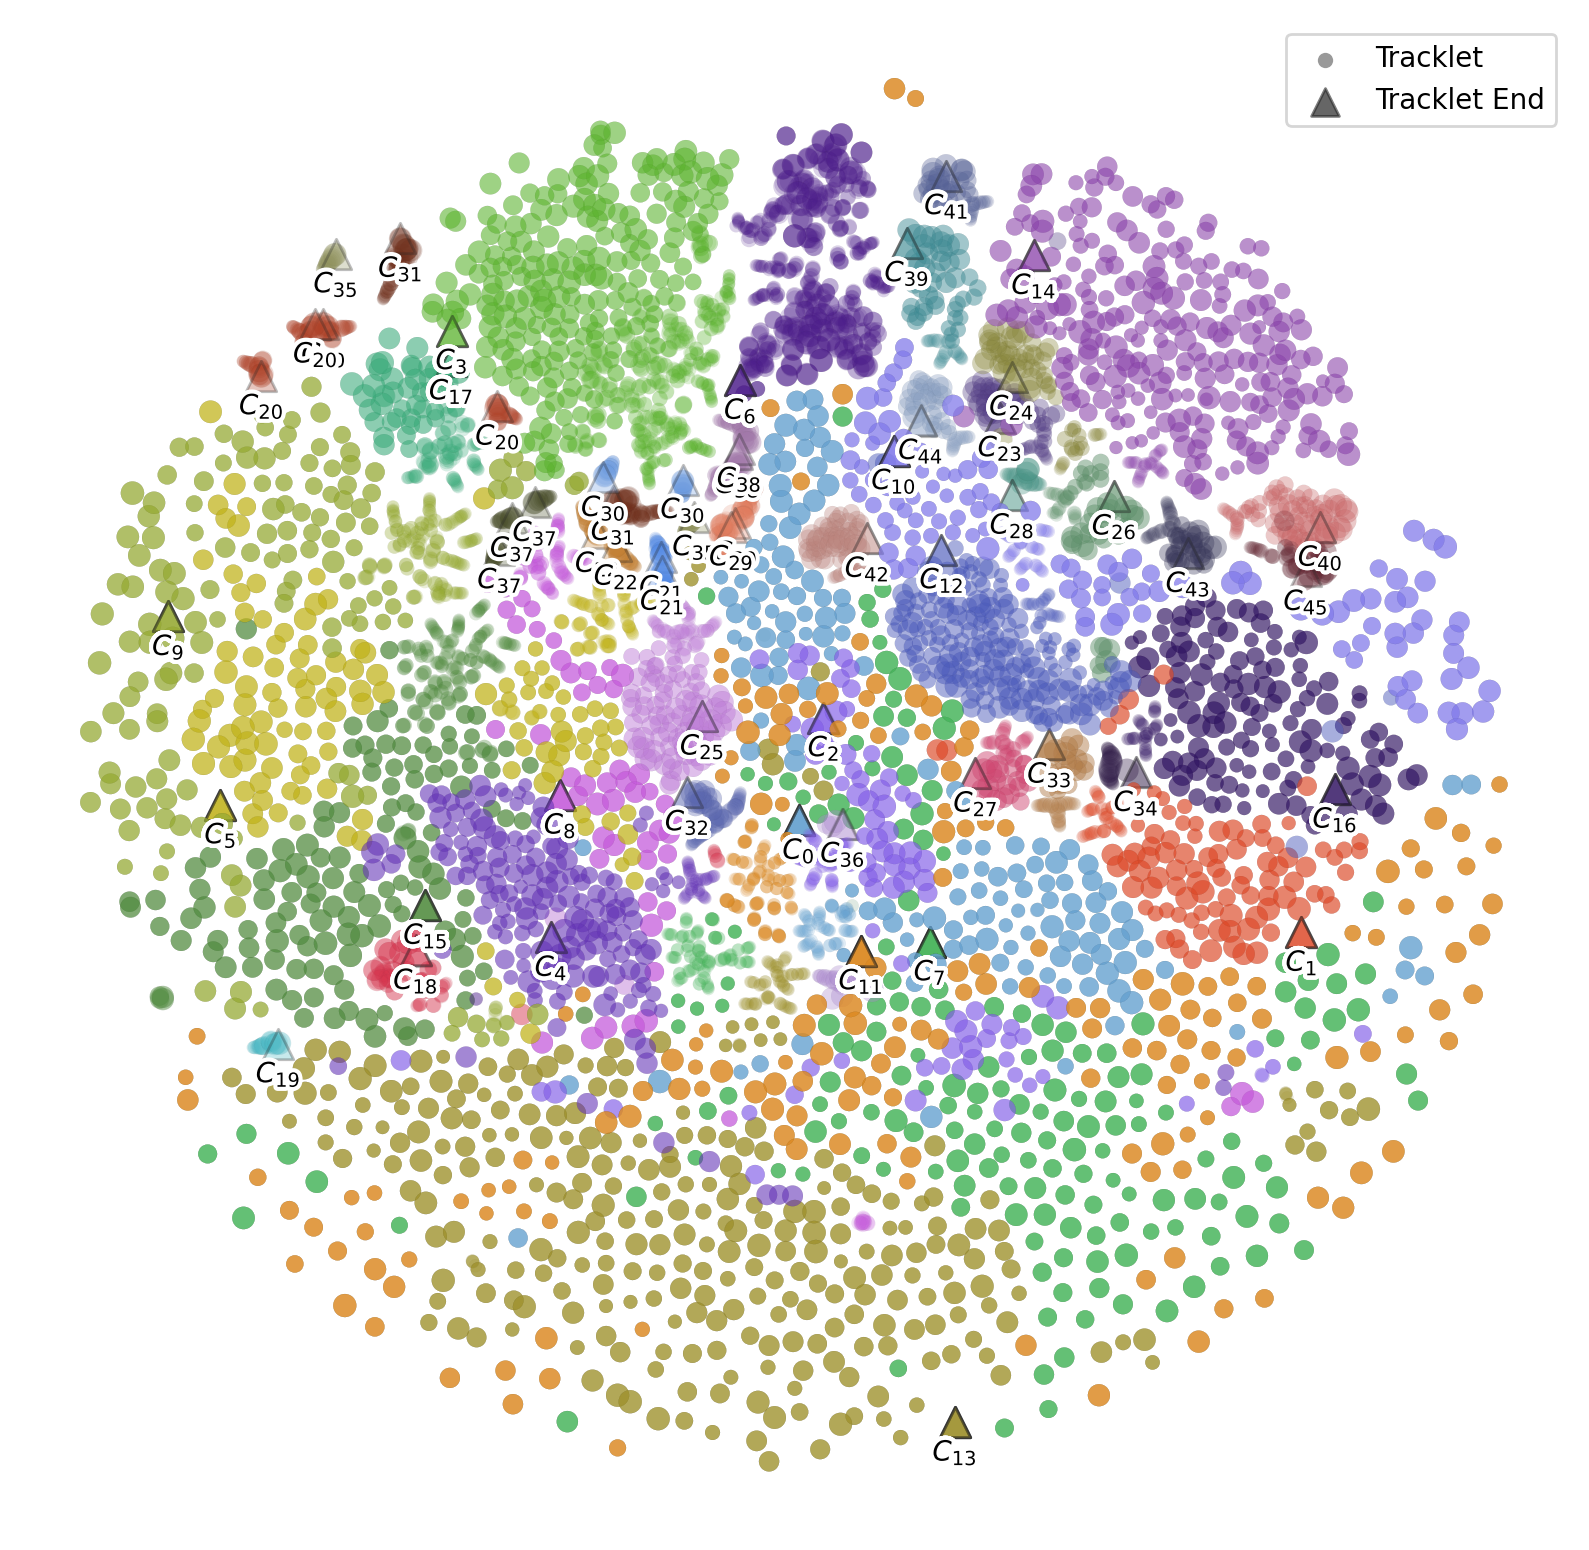

In [14]:
colors = numpy.asarray(
    [
        [102, 162, 209], [222, 74, 41], [132, 96, 233], [94, 181, 49],
        [102, 54, 184], [194, 180, 29], [78, 31, 140], [72, 182, 92],
        [198, 92, 220], [151, 171, 52], [130, 123, 235], [221, 139, 36],
        [76, 91, 188], [159, 146, 46], [140, 68, 172], [83, 141, 65],
        [50, 21, 99], [61, 173, 125], [214, 54, 79], [70, 183, 195],
        [175, 66, 40], [83, 138, 229], [195, 128, 52], [84, 62, 134],
        [137, 135, 60], [191, 127, 216], [97, 147, 110], [208, 72, 114],
        [73, 148, 134], [224, 124, 94], [107, 154, 223], [114, 50, 30],
        [92, 104, 176], [179, 126, 75], [48, 28, 72], [144, 146, 93],
        [173, 140, 208], [71, 76, 39], [162, 120, 170], [65, 141, 150],
        [203, 105, 106], [86, 98, 151], [188, 133, 126], [59, 58, 93],
        [137, 159, 193], [101, 40, 52], [72, 99, 130],
    ]
)

plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=200)

reductionTracklets = [reduction[range[0] : range[1]] for range in trainIdeces]
labelTracklets = [list(set(trainLabelsAll[range[0] : range[1]] - 1))[0] for range in trainIdeces]
faceColors = [colors[int(label)] / 255.0 for label in labelTracklets]
labelSize = [list(numpy.linspace(20, 70, num=(r[1] - r[0])-2)) for r in trainIdeces]
faceAlpha = [list(numpy.linspace(0.05, 0.6, num=(r[1] - r[0])-2)) for r in trainIdeces]

for i in range(len(reductionTracklets)):
    r = reductionTracklets[i]
    plt.scatter(
        r[:, 0][0:-2], r[:, 1][0:-2],
        s=labelSize[i], alpha=0.2,
        edgecolor="#262626",
        linewidth=0.02,
        color=faceColors[i],
    )
    plt.scatter(
        r[:, 0][-1], r[:, 1][-1],
        s=120, alpha=0.3,
        edgecolor="#262626",
        marker="^",
        linewidth=1,
        color=faceColors[i],
    )
    text = ax.text(r[:, 0][-1], r[:, 1][-1]-6, f"$C_{{{int(labelTracklets[i])}}}$",
        fontsize=10,
        horizontalalignment="center",
        verticalalignment="center",
    )
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

plt.scatter(
    [], [],
    s=30, alpha=0.4,
    edgecolor="#262626",
    linewidth=0.02,
    color='black',
    label='Tracklet'
)
plt.scatter(
    [], [],
    s=100, alpha=0.6,
    edgecolor="#262626",
    marker="^",
    linewidth=1,
    color='black',
    label='Tracklet End'
)

# Viz tweaks https://olgabotvinnik.com/blog/prettyplotlib-painlessly-create-beautiful-matplotlib
[ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axis("tight")
ax.legend()
plt.show()